## **1. Google Drive**

In [5]:
from google.colab import drive
drive.mount('/content/drive')
cur_dir = "/content/drive/MyDrive/CH2/Notebooks"
%cd $cur_dir


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/CH2/Notebooks


In [6]:
%pip install torchview


## **2. Import Libraries**

In [7]:
# Set seed for reproducibility
SEED = 42

# Import necessary libraries
import os

# Set environment variables before importing modules
os.environ['PYTHONHASHSEED'] = str(SEED)
os.environ['MPLCONFIGDIR'] = os.getcwd() + '/configs/'
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

# Suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

# Import necessary modules
import logging
import random
import numpy as np

# Set seeds for random number generators in NumPy and Python
np.random.seed(SEED)
random.seed(SEED)

# Import PyTorch
import torch
torch.manual_seed(SEED)
from torch import nn
from torchsummary import summary
from torch.utils.tensorboard import SummaryWriter
import torchvision
from torchvision.transforms import v2 as transforms
from torch.utils.data import TensorDataset, DataLoader
from torchview import draw_graph
from scipy import ndimage
from PIL import Image
from transformers import AutoModel, AutoImageProcessor

# Configurazione di TensorBoard e directory
logs_dir = "tensorboard"
!pkill -f tensorboard
%load_ext tensorboard
!mkdir -p models

if torch.cuda.is_available():
    device = torch.device("cuda")
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.benchmark = True
else:
    device = torch.device("cpu")

print(f"PyTorch version: {torch.__version__}")
print(f"Device: {device}")

# Import other libraries
import cv2
import copy
import shutil
from itertools import product
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
from PIL import Image
import matplotlib.gridspec as gridspec
import requests
from io import BytesIO
from tqdm import tqdm
import glob
from pathlib import Path
import shutil
import gc
from sklearn.preprocessing import LabelEncoder
from datetime import datetime

# Configure plot display settings
sns.set(font_scale=1.4)
sns.set_style('white')
plt.rc('font', size=14)
%matplotlib inline

PyTorch version: 2.9.0+cu126
Device: cuda


## **3. Config**

In [8]:
USE_MASKED_PATCHES = False

In [9]:
datasets_path = os.path.join(os.path.pardir, "an2dl2526c2")

train_data_path = os.path.join(datasets_path, "train_data")
train_labels_path = os.path.join(datasets_path, "train_labels.csv")
test_data_path = os.path.join(datasets_path, "test_data")

CSV_PATH = train_labels_path                # Path to the CSV file with labels
SOURCE_FOLDER = train_data_path

if USE_MASKED_PATCHES:
  PATCHES_OUT = os.path.join(datasets_path, "preprocessing_results_masked","train_patches_masked")
  SUBMISSION_PATCHES_OUT = os.path.join(datasets_path, "preprocessing_results_masked","submission_patches_masked")
else:
  PATCHES_OUT = os.path.join(datasets_path, "preprocessing_results","train_patches")
  SUBMISSION_PATCHES_OUT = os.path.join(datasets_path, "preprocessing_results","submission_patches")

print(f"Dataset path: {datasets_path}")
print(f"Train data path: {train_data_path}")
print(f"Train labels path: {train_labels_path}")
print(f"Test data path: {test_data_path}")
print(f"Patches output path: {PATCHES_OUT}")
print(f"Submission patches output path: {SUBMISSION_PATCHES_OUT}")




TARGET_SIZE = (224, 224)                    # Target size for the resized images and masks

Dataset path: ../an2dl2526c2
Train data path: ../an2dl2526c2/train_data
Train labels path: ../an2dl2526c2/train_labels.csv
Test data path: ../an2dl2526c2/test_data
Patches output path: ../an2dl2526c2/preprocessing_results/train_patches
Submission patches output path: ../an2dl2526c2/preprocessing_results/submission_patches


## **4. Train/Val Split**

In [10]:
def create_metadata_dataframe(patches_dir, labels_csv_path):
    """
    Creates a DataFrame mapping patch filenames to their Bag IDs and Labels.
    """
    # 1. Load the labels CSV
    # Assuming CSV structure: [image_id, label] or similar
    df_labels = pd.read_csv(labels_csv_path)

    # Standardize column names for easier merging
    # We assume the first column is the ID and the second is the Label
    id_col = df_labels.columns[0]
    label_col = df_labels.columns[1]

    # Ensure IDs in CSV are strings (to match filenames)
    df_labels[id_col] = df_labels[id_col].astype(str)

    # If the CSV IDs contain extensions (e.g., 'img_001.png'), remove them
    # because our parsed Bag IDs won't have them.
    df_labels[id_col] = df_labels[id_col].apply(lambda x: os.path.splitext(x)[0])

    # 2. List all patch files
    patch_files = [f for f in os.listdir(patches_dir) if f.endswith('.png')]

    # 3. Parse filenames to get Bag IDs
    data = []
    print(f"Found {len(patch_files)} patches. Parsing metadata...")

    for filename in patch_files:
        # Expected format from your preprocessing: {base_name}_p{i}.png
        # Example: "img_0015_p12.png" -> Bag ID should be "img_0015"

        # Split from the right on '_p' to separate Bag ID from Patch Index
        # "img_0015_p12.png" -> ["img_0015", "12.png"]
        try:
            bag_id = filename.rsplit('_p', 1)[0]

            data.append({
                'filename': filename,
                'sample_id': bag_id,
                'path': os.path.join(patches_dir, filename)
            })
        except IndexError:
            print(f"Skipping malformed filename: {filename}")

    # Create temporary patches DataFrame
    df_patches = pd.DataFrame(data)

    # 4. Merge patches with labels
    # This assigns the correct Bag Label to every Patch in that Bag
    df = pd.merge(df_patches, df_labels, left_on='sample_id', right_on=id_col, how='inner')

    # 5. Clean up and Rename
    # Keep only required columns
    df = df[['filename', label_col, 'sample_id', 'path']]

    # Rename label column to standard 'label' if it isn't already
    df = df.rename(columns={label_col: 'label'})

    print(f"Successfully created DataFrame with {len(df)} rows.")
    return df

In [11]:
patches_metadata_df = create_metadata_dataframe(PATCHES_OUT, CSV_PATH)

# Verify the result
print("\nFirst 5 rows:")
print(patches_metadata_df.head().drop(columns=['path']))
print("\nPatches per Bag (Distribution):")
print(patches_metadata_df['sample_id'].value_counts().describe())

Found 2788 patches. Parsing metadata...
Successfully created DataFrame with 2788 rows.

First 5 rows:
          filename            label sample_id
0  img_0446_p3.png  Triple negative  img_0446
1  img_0446_p4.png  Triple negative  img_0446
2  img_0446_p5.png  Triple negative  img_0446
3  img_0446_p6.png  Triple negative  img_0446
4  img_0446_p7.png  Triple negative  img_0446

Patches per Bag (Distribution):
count    631.000000
mean       4.418384
std        2.771610
min        1.000000
25%        3.000000
50%        4.000000
75%        6.000000
max       23.000000
Name: count, dtype: float64


In [12]:
# Add Label Encoding
print("\n" + "="*50)
print("Label Encoding")
print("="*50)

label_encoder = LabelEncoder()
patches_metadata_df['label_encoded'] = label_encoder.fit_transform(patches_metadata_df['label'])

print(f"\nOriginal Labels: {label_encoder.classes_}")
print(f"Encoded as: {list(range(len(label_encoder.classes_)))}")
print(f"\nLabel Mapping:")
for orig, enc in zip(label_encoder.classes_, range(len(label_encoder.classes_))):
    print(f"  {orig} -> {enc}")


Label Encoding

Original Labels: ['HER2(+)' 'Luminal A' 'Luminal B' 'Triple negative']
Encoded as: [0, 1, 2, 3]

Label Mapping:
  HER2(+) -> 0
  Luminal A -> 1
  Luminal B -> 2
  Triple negative -> 3


In [13]:
# Train/Val Split on Original Images (not patches)
print("\n" + "="*50)
print("Train/Val Split on Original Images")
print("="*50)

# Get unique sample IDs
unique_samples = patches_metadata_df['sample_id'].unique()
print(f"\nTotal unique samples (original images): {len(unique_samples)}")

# Split samples into train (80%) and val (20%)
train_samples, val_samples = train_test_split(
    unique_samples,
    test_size=0.2,
    random_state=SEED,
    stratify=patches_metadata_df.drop_duplicates('sample_id').set_index('sample_id').loc[unique_samples, 'label_encoded'].values
)

print(f"Train samples: {len(train_samples)}")
print(f"Val samples: {len(val_samples)}")

# Create train and val DataFrames by filtering patches
df_train = patches_metadata_df[patches_metadata_df['sample_id'].isin(train_samples)].reset_index(drop=True)
df_val = patches_metadata_df[patches_metadata_df['sample_id'].isin(val_samples)].reset_index(drop=True)

print(f"\nTrain patches: {len(df_train)}")
print(f"Val patches: {len(df_val)}")
print(f"\nTrain label distribution:\n{df_train['label'].value_counts()}")
print(f"\nVal label distribution:\n{df_val['label'].value_counts()}")

# Print percentage distribution
print(f"\n" + "="*50)
print("Percentage Distribution")
print("="*50)
print(f"\nTrain label percentage:\n{df_train['label'].value_counts(normalize=True) * 100}")
print(f"\nVal label percentage:\n{df_val['label'].value_counts(normalize=True) * 100}")


Train/Val Split on Original Images

Total unique samples (original images): 631
Train samples: 504
Val samples: 127

Train patches: 2210
Val patches: 578

Train label distribution:
label
Luminal B          797
HER2(+)            593
Luminal A          593
Triple negative    227
Name: count, dtype: int64

Val label distribution:
label
Luminal A          177
HER2(+)            174
Luminal B          167
Triple negative     60
Name: count, dtype: int64

Percentage Distribution

Train label percentage:
label
Luminal B          36.063348
HER2(+)            26.832579
Luminal A          26.832579
Triple negative    10.271493
Name: proportion, dtype: float64

Val label percentage:
label
Luminal A          30.622837
HER2(+)            30.103806
Luminal B          28.892734
Triple negative    10.380623
Name: proportion, dtype: float64


## **5. Transformations & Augmentation**

In [14]:
# Define augmentation for training with enhanced transformations
train_augmentation = transforms.Compose([
    # Geometric transformations
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    #transforms.RandomRotation(degrees=15),  # Small rotations to handle orientation variations
    #transforms.RandomAffine(
    #    degrees=0,
    #    translate=(0.1, 0.1),  # Reduced from 0.2 for more conservative shifts
    #    scale=None,  # Add scale variation
    #    shear=10  # Add shear transformation
    #),

    # Color/appearance transformations
    #transforms.ColorJitter(
    #    brightness=0.2,  # Adjust brightness
    #    contrast=0.2,    # Adjust contrast
    #    saturation=0.2,  # Adjust saturation
    #    hue=0.1          # Slight hue variation
    #),
    #transforms.RandomGrayscale(p=0.1),  # Occasionally convert to grayscale to improve robustness

    # Occlusion simulation
    #transforms.RandomErasing(
    #    p=0.1,  # Reduced probability for more balanced augmentation
    #    scale=(0.02, 0.15),  # Reduced max scale
    #    ratio=(0.3, 3.3)  # Aspect ratio range
    #),

    # Optional: Add Gaussian blur for noise robustness
    # transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0))
])

## **6. Custom Dataset Class**

In [15]:
# Load the Phikon image processor
phikon_processor = AutoImageProcessor.from_pretrained("owkin/phikon")

# ImageNet normalization statistics (fallback)
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]

class TissueDataset(torch.utils.data.Dataset):
    """Custom PyTorch Dataset for loading images with Phikon preprocessing."""

    def __init__(self, df, augmentation=None, use_phikon_processor=True):
        """
        Args:
            df (pd.DataFrame): DataFrame with 'path' and 'label_encoded' columns.
            augmentation (callable, optional): Augmentation transforms to be applied on a sample.
            use_phikon_processor (bool): If True, uses Phikon's official preprocessor.
        """
        self.df = df
        self.augmentation = augmentation
        self.use_phikon_processor = use_phikon_processor

        if use_phikon_processor:
            self.processor = phikon_processor
        else:
            # Fallback: manual preprocessing
            self.to_tensor = transforms.Compose([
                transforms.Resize(TARGET_SIZE),
                transforms.ToImage(),
                transforms.ToDtype(torch.float32, scale=True)
            ])
            self.normalize = transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = self.df.iloc[idx]['path']
        label = self.df.iloc[idx]['label_encoded']

        # Load image
        image = Image.open(img_path).convert('RGB')

        if self.use_phikon_processor:
            # Use Phikon's official processor
            processed = self.processor(image, return_tensors="pt")
            image_tensor = processed['pixel_values'].squeeze(0)
        else:
            # Manual preprocessing
            image_tensor = self.to_tensor(image)
            if self.augmentation:
                image_tensor = self.augmentation(image_tensor)
            image_tensor = self.normalize(image_tensor)

        # Apply augmentation if using Phikon processor
        if self.use_phikon_processor and self.augmentation:
            image_tensor = self.augmentation(image_tensor)

        return image_tensor, label

preprocessor_config.json:   0%|          | 0.00/171 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/492 [00:00<?, ?B/s]

Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.


## **7. Data Loaders**

In [16]:
# Instantiate Datasets with Phikon processor
train_dataset = TissueDataset(df_train, augmentation=train_augmentation, use_phikon_processor=True)
val_dataset = TissueDataset(df_val, augmentation=None, use_phikon_processor=True)

# Batch Size: 32 or 64 is standard for ResNet18/50 on 1MP images
BATCH_SIZE = 64

cpu_cores = os.cpu_count() or 2
num_workers = max(2, min(4, cpu_cores))
# Instantiate Loaders
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,          # Shuffle patches to break batch correlations
    num_workers=num_workers,         # Adjust based on your CPU
    pin_memory=True        # Faster data transfer to CUDA
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,         # No need to shuffle validation
    num_workers=num_workers,
    pin_memory=True
)

print(f"Train Loader: {len(train_loader)} batches")
print(f"Val Loader: {len(val_loader)} batches")
print(f"Num workers: {train_loader.num_workers}")

Train Loader: 35 batches
Val Loader: 10 batches
Num workers: 4


In [17]:
def show_batch(loader, count=4):
    images, labels = next(iter(loader))
    plt.figure(figsize=(15, 5))

    # Denormalize for visualization
    mean = torch.tensor(IMAGENET_MEAN).view(3, 1, 1)
    std = torch.tensor(IMAGENET_STD).view(3, 1, 1)

    for i in range(count):
        ax = plt.subplot(1, count, i + 1)

        img = images[i]
        #img = img * std + mean  # Un-normalize

        img = torch.clamp(img, 0, 1)  # Clip to valid range

        plt.imshow(img.permute(1, 2, 0)) # CHW -> HWC
        plt.title(f"Label: {labels[i].item()}")
        plt.axis("off")
    plt.show()





Visualizing Training Batch (Augmented):


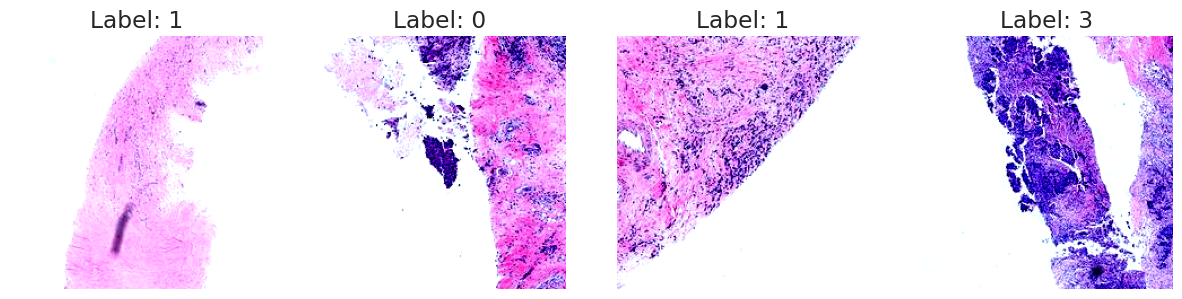

In [18]:
print("\nVisualizing Training Batch (Augmented):")
show_batch(train_loader)

## **8. Hyperparameters**

In [19]:
DROPOUT_RATE = 0.3
HIDDEN_SIZE = 512
L2_REG = 1e-4

NUM_EPOCHS = 100  # Increased since we have early stopping
PATIENCE = 8    # Stop if val_loss doesn't improve for 5 epochs

## **9. Model Definition (Transfer Learning - PhikonV2)**

In [20]:
from transformers import AutoModel
class AttentionPooling(nn.Module):
    def __init__(self, embedding_dim):
        super().__init__()
        self.attention = nn.Linear(embedding_dim, 1)

    def forward(self, x):
        # x shape: [batch_size, seq_len, embedding_dim]
        weights = torch.softmax(self.attention(x), dim=1)  # [batch_size, seq_len, 1]
        return (x * weights).sum(dim=1)  # [batch_size, embedding_dim]

class PhikonClassifier(nn.Module):
    def __init__(self, num_classes, model_name="owkin/phikon", dropout_rate=0.3, freeze_backbone=True):
        super().__init__()

        print(f"Loading Phikon backbone: {model_name}...")
        self.backbone = AutoModel.from_pretrained(model_name)

        if "v2" in model_name:
            self.embedding_dim = 1024
        else:
            self.embedding_dim = 768

        if freeze_backbone:
            for param in self.backbone.parameters():
                param.requires_grad = False

        # Attention pooling instead of just taking CLS token
        self.attention_pool = AttentionPooling(self.embedding_dim)

        # Classifier head
        self.classifier = nn.Sequential(
            nn.Linear(self.embedding_dim, 64),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout_rate),
            nn.Linear(64, num_classes),
        )

    def forward(self, x):
        outputs = self.backbone(pixel_values=x)
        tokens = outputs.last_hidden_state  # [batch_size, seq_len, embedding_dim]

        # Apply attention pooling
        pooled = self.attention_pool(tokens)  # [batch_size, embedding_dim]

        return self.classifier(pooled)

In [21]:
# Initialize the model
# Ensure device is defined (usually from previous cells, but safe to redefine if standalone)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Assuming label_encoder is defined in your notebook scope
num_classes = len(label_encoder.classes_)
model = PhikonClassifier(
    num_classes=num_classes,
    model_name="owkin/phikon",  # Change to "owkin/phikon-v2" for the larger model
    dropout_rate=DROPOUT_RATE
)
model = model.to(device)

print(f"Model initialized (Phikon) with {num_classes} output classes.")




Loading Phikon backbone: owkin/phikon...


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Model initialized (Phikon) with 4 output classes.


## **10. Loss and Optimizer**

In [22]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=None, gamma=2.0):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.ce = nn.CrossEntropyLoss(weight=alpha, reduction='none')

    def forward(self, inputs, targets):
        ce_loss = self.ce(inputs, targets)
        pt = torch.exp(-ce_loss)
        focal_loss = ((1 - pt) ** self.gamma) * ce_loss
        return focal_loss.mean()

In [23]:
# Re-define loss and optimizer for the new model

# Set a scalar alpha for Focal Loss

alpha = None
criterion = FocalLoss(alpha=alpha, gamma=2.3)

# Only optimize parameters that require gradients (the head)
# The backbone is frozen by default in the class above
optimizer = torch.optim.RAdam(
    [p for p in model.parameters() if p.requires_grad],
    lr=1e-3,
    weight_decay=L2_REG
)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.1, patience=3
)

print("Optimizer and Scheduler reset for Phikon with Focal Loss (scalar alpha).")

Optimizer and Scheduler reset for Phikon with Focal Loss (scalar alpha).


## **11. Function: Training & Validation Loop**

In [24]:
def train_one_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0

    # Lists to store all predictions and labels for F1 calculation
    all_preds = []
    all_labels = []

    loop = tqdm(loader, leave=False)

    for images, labels in loop:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Metrics accumulation
        running_loss += loss.item() * images.size(0)

        _, predicted = torch.max(outputs, 1)

        # Move to CPU and convert to numpy for sklearn metrics
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

        loop.set_description(f"Loss: {loss.item():.4f}")

    epoch_loss = running_loss / len(loader.dataset)
    # Calculate F1 Score (Macro for imbalanced data)
    epoch_f1 = f1_score(all_labels, all_preds, average='macro')

    return epoch_loss, epoch_f1

def validate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    epoch_loss = running_loss / len(loader.dataset)
    epoch_f1 = f1_score(all_labels, all_preds, average='macro')

    return epoch_loss, epoch_f1

## **12. Training Loop: Transfer Learning**

### 12.1 Training

In [25]:
best_val_f1 = 0.0
best_val_loss = float('inf')
patience_counter = 0
best_tl_epoch = 0
model_saved = False

history = {'train_loss': [], 'train_f1': [], 'val_loss': [], 'val_f1': []}

print(f"Starting Training with Phikonv2 (Patience: {PATIENCE})...")

for epoch in range(NUM_EPOCHS):
    # Train
    train_loss, train_f1 = train_one_epoch(model, train_loader, criterion, optimizer, device)

    # Validate
    val_loss, val_f1 = validate(model, val_loader, criterion, device)

    # Update Scheduler (based on Loss)
    scheduler.step(val_loss)

    # Store history
    history['train_loss'].append(train_loss)
    history['train_f1'].append(train_f1)
    history['val_loss'].append(val_loss)
    history['val_f1'].append(val_f1)


    # --- Checkpointing (Save Best Model based on F1) ---
    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        torch.save(model.state_dict(), 'models/best_model_phikonv2_tl.pt')
        model_saved = True
        patience_counter = 0  # Reset counter
        best_tl_epoch = epoch + 1
    else:
        model_saved = False
        patience_counter += 1

    if model_saved:
        print(f"TL Epoch {epoch+1}/{NUM_EPOCHS} | Loss: {train_loss:.4f} | F1: {train_f1:.4f} | Val Loss: {val_loss:.4f} | Val F1: {val_f1:.4f} | Patience: {patience_counter}/{PATIENCE} ✓")
    else:
        print(f"TL Epoch {epoch+1}/{NUM_EPOCHS} | Loss: {train_loss:.4f} | F1: {train_f1:.4f} | Val Loss: {val_loss:.4f} | Val F1: {val_f1:.4f} | Patience: {patience_counter}/{PATIENCE}")

    if patience_counter >= PATIENCE:
        print("   >>> Early Stopping Triggered! Training stopped.")
        break

Starting Training with Phikonv2 (Patience: 8)...


TL Epoch 1/100 | Loss: 0.7005 | F1: 0.2675 | Val Loss: 0.6500 | Val F1: 0.2353 | Patience: 0/8 ✓


TL Epoch 2/100 | Loss: 0.6280 | F1: 0.2905 | Val Loss: 0.6137 | Val F1: 0.3167 | Patience: 0/8 ✓


TL Epoch 3/100 | Loss: 0.5908 | F1: 0.3412 | Val Loss: 0.6085 | Val F1: 0.2884 | Patience: 1/8


TL Epoch 4/100 | Loss: 0.5619 | F1: 0.3940 | Val Loss: 0.6013 | Val F1: 0.3810 | Patience: 0/8 ✓


TL Epoch 5/100 | Loss: 0.5373 | F1: 0.4566 | Val Loss: 0.5963 | Val F1: 0.3508 | Patience: 1/8


TL Epoch 6/100 | Loss: 0.5141 | F1: 0.4530 | Val Loss: 0.6039 | Val F1: 0.4098 | Patience: 0/8 ✓


TL Epoch 7/100 | Loss: 0.4979 | F1: 0.5006 | Val Loss: 0.5965 | Val F1: 0.3872 | Patience: 1/8


TL Epoch 8/100 | Loss: 0.4793 | F1: 0.5134 | Val Loss: 0.5979 | Val F1: 0.4293 | Patience: 0/8 ✓


TL Epoch 9/100 | Loss: 0.4626 | F1: 0.5182 | Val Loss: 0.6095 | Val F1: 0.3759 | Patience: 1/8


TL Epoch 10/100 | Loss: 0.4500 | F1: 0.5390 | Val Loss: 0.6027 | Val F1: 0.4220 | Patience: 2/8


TL Epoch 11/100 | Loss: 0.4368 | F1: 0.5655 | Val Loss: 0.6004 | Val F1: 0.4302 | Patience: 0/8 ✓


TL Epoch 12/100 | Loss: 0.4348 | F1: 0.5667 | Val Loss: 0.5994 | Val F1: 0.4277 | Patience: 1/8


TL Epoch 13/100 | Loss: 0.4323 | F1: 0.5875 | Val Loss: 0.6016 | Val F1: 0.4146 | Patience: 2/8


TL Epoch 14/100 | Loss: 0.4280 | F1: 0.5774 | Val Loss: 0.6008 | Val F1: 0.4242 | Patience: 3/8


TL Epoch 15/100 | Loss: 0.4270 | F1: 0.5680 | Val Loss: 0.6004 | Val F1: 0.4259 | Patience: 4/8


TL Epoch 16/100 | Loss: 0.4223 | F1: 0.5847 | Val Loss: 0.5997 | Val F1: 0.4269 | Patience: 5/8


TL Epoch 17/100 | Loss: 0.4228 | F1: 0.5798 | Val Loss: 0.5995 | Val F1: 0.4308 | Patience: 0/8 ✓


TL Epoch 18/100 | Loss: 0.4313 | F1: 0.5664 | Val Loss: 0.5995 | Val F1: 0.4323 | Patience: 0/8 ✓


TL Epoch 19/100 | Loss: 0.4302 | F1: 0.5661 | Val Loss: 0.5995 | Val F1: 0.4323 | Patience: 1/8


TL Epoch 20/100 | Loss: 0.4246 | F1: 0.5659 | Val Loss: 0.5995 | Val F1: 0.4323 | Patience: 2/8


TL Epoch 21/100 | Loss: 0.4245 | F1: 0.5792 | Val Loss: 0.5994 | Val F1: 0.4323 | Patience: 3/8


TL Epoch 22/100 | Loss: 0.4247 | F1: 0.5782 | Val Loss: 0.5994 | Val F1: 0.4323 | Patience: 4/8


TL Epoch 23/100 | Loss: 0.4222 | F1: 0.5825 | Val Loss: 0.5995 | Val F1: 0.4323 | Patience: 5/8


TL Epoch 24/100 | Loss: 0.4256 | F1: 0.5788 | Val Loss: 0.5995 | Val F1: 0.4323 | Patience: 6/8


TL Epoch 25/100 | Loss: 0.4273 | F1: 0.5695 | Val Loss: 0.5995 | Val F1: 0.4323 | Patience: 7/8


TL Epoch 26/100 | Loss: 0.4298 | F1: 0.5740 | Val Loss: 0.5995 | Val F1: 0.4323 | Patience: 8/8
   >>> Early Stopping Triggered! Training stopped.


### 12.2 Training History

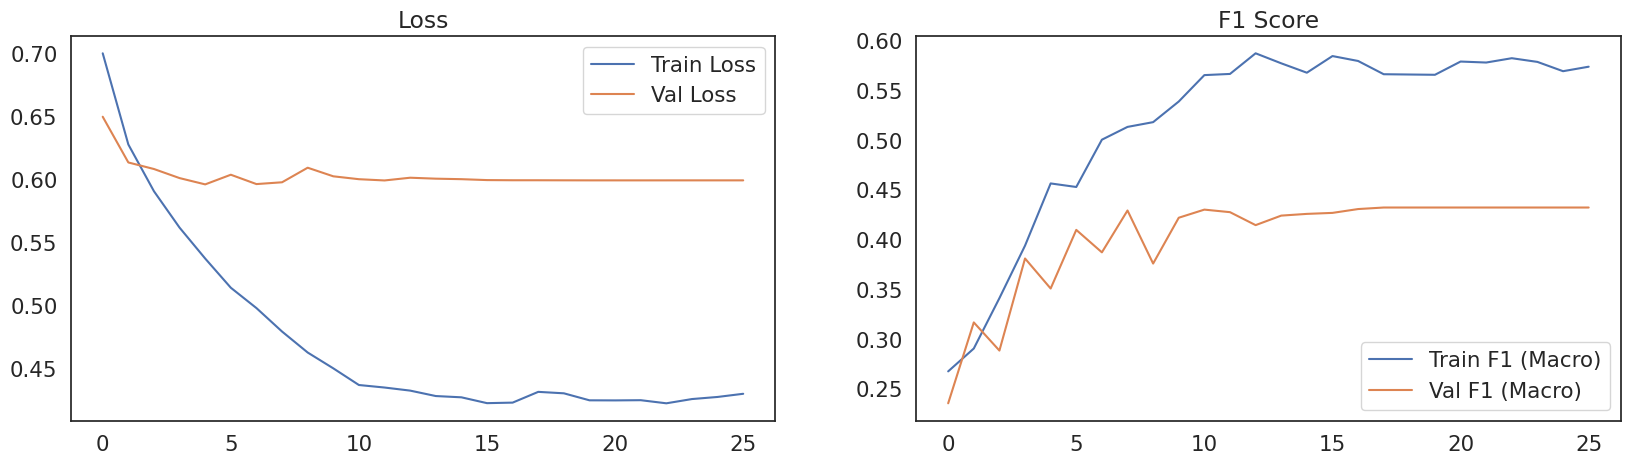

Best Validation F1 Score: 0.4323 at epoch 18


In [26]:
# Plotting results
plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss')

plt.subplot(1, 2, 2)
plt.plot(history['train_f1'], label='Train F1 (Macro)')
plt.plot(history['val_f1'], label='Val F1 (Macro)')
plt.legend()
plt.title('F1 Score')
plt.show()

print("Best Validation F1 Score: {:.4f} at epoch {}".format(best_val_f1, best_tl_epoch))

### 12.3 Function: Generate Predictions

In [32]:
def get_image_predictions(model, loader, device):
    """
    Aggregates patch-level predictions to image-level.
    Strategy: Average the Softmax probabilities of all patches in a bag,
    then take the argmax. This handles 'noisy/benign' patches well.
    """
    model.eval()

    # Access the dataframe stored in the dataset
    dataset = loader.dataset
    df = dataset.df
    # dataset.transform does not exist in TissueDataset

    y_true = []
    y_pred = []

    # Get unique sample IDs (original images)
    sample_ids = df['sample_id'].unique()

    print(f"\nAggregating predictions for {len(sample_ids)} unique images...")

    for sample_id in tqdm(sample_ids, leave=False):
        # Get all patches belonging to this image
        sample_patches = df[df['sample_id'] == sample_id]

        # Ground Truth (all patches share the image label)
        true_label = sample_patches.iloc[0]['label_encoded']
        y_true.append(true_label)

        # Load and process all patches for this image
        patches = []
        for img_path in sample_patches['path']:
            try:
                # Load image (ensure RGB)
                img = Image.open(img_path).convert('RGB')

                # Use Phikon Preprocessing
                processed = phikon_processor(img, return_tensors="pt")
                img_tensor = processed['pixel_values'].squeeze(0)

                patches.append(img_tensor)
            except Exception as e:
                continue

        if not patches:
            y_pred.append(true_label) # Fallback (should not happen)
            continue

        # Stack patches into a single batch: [Num_Patches, 3, 224, 224]
        batch = torch.stack(patches).to(device)

        with torch.no_grad():
            logits = model(batch)
            probs = torch.softmax(logits, dim=1)

            # --- Aggregation: Mean Probability ---
            # Averaging probabilities reduces the impact of outliers (benign patches)
            avg_probs = torch.mean(probs, dim=0)
            pred_label = torch.argmax(avg_probs).item()

        y_pred.append(pred_label)

    return y_true, y_pred

### 12.4 Confusion Matrix

Generating Confusion Matrix on Original Images...

Aggregating predictions for 127 unique images...


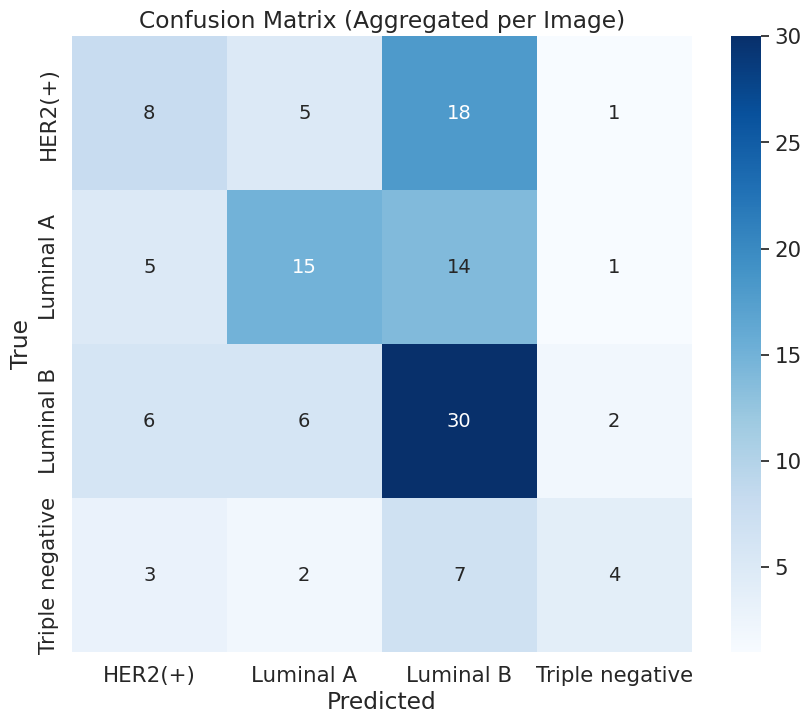

In [33]:

# 3. Calculate and Plot Confusion Matrix
print("Generating Confusion Matrix on Original Images...")
y_true_img, y_pred_img = get_image_predictions(model, val_loader, device)

# Compute Matrix
cm = confusion_matrix(y_true_img, y_pred_img)

# Plotting
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (Aggregated per Image)')
plt.show()


In [37]:
def plot_sample_with_predictions(model, loader, device, label_encoder, sample_id=None, aggregation_method='max_confidence', normalize_imagenet=False):
    """Plot all patches of a single sample and the aggregated image prediction."""
    import math
    model.eval()
    dataset = loader.dataset
    df = dataset.df

    # Pick a sample_id
    if sample_id is None:
        sample_id = np.random.choice(df['sample_id'].unique())
    sample_patches = df[df['sample_id'] == sample_id].reset_index(drop=True)

    # Load and transform all patches
    images_tensors = []
    display_imgs = []

    # Define display transform (just to tensor for visualization)
    to_tensor = transforms.ToTensor()

    for _, row in sample_patches.iterrows():
        img = Image.open(row['path']).convert('RGB')

        # 1. Prepare for Model (Phikon Processor)
        # Using global phikon_processor
        processed = phikon_processor(img, return_tensors="pt")
        tensor_img = processed['pixel_values'].squeeze(0)
        images_tensors.append(tensor_img)

        # 2. Prepare for Display
        # We use the raw image converted to tensor for visualization to avoid normalization artifacts
        display_imgs.append(to_tensor(img))

    batch = torch.stack(images_tensors).to(device)
    with torch.no_grad():
        logits = model(batch)
        probs = torch.softmax(logits, dim=1).cpu()

    patch_preds = probs.argmax(dim=1).numpy()
    patch_confs = probs.max(dim=1).values.numpy()

    if aggregation_method == 'max_confidence':
        # Average probabilities (Soft Voting)
        image_probs = probs.mean(dim=0).numpy()
        image_pred = image_probs.argmax()
        image_conf = image_probs[image_pred]
    elif aggregation_method == 'majority_voting':
        # Hard Voting
        counts = np.bincount(patch_preds, minlength=len(label_encoder.classes_))
        image_pred = counts.argmax()
        # Normalize counts for visualization purposes
        image_probs = counts / counts.sum()
        image_conf = image_probs[image_pred]
    else:
        raise ValueError(f"Unknown aggregation method: {aggregation_method}")

    image_pred_label = label_encoder.inverse_transform([image_pred])[0]
    true_label = label_encoder.inverse_transform([sample_patches.iloc[0]['label_encoded']])[0]

    cols = min(6, len(sample_patches))
    rows = math.ceil(len(sample_patches) / cols)
    fig = plt.figure(figsize=(3*cols + 4, 3*rows))
    gs = fig.add_gridspec(rows, cols + 1, width_ratios=[1]*cols + [1.3])

    # Patch grid
    for idx, (img_disp, pred, conf) in enumerate(zip(display_imgs, patch_preds, patch_confs)):
        ax = fig.add_subplot(gs[idx // cols, idx % cols])
        ax.imshow(img_disp.permute(1,2,0))
        lbl = label_encoder.inverse_transform([pred])[0]
        ax.set_title(f"{lbl}\n{conf:.2%}", fontsize=9)
        ax.axis('off')

    # Aggregated distribution
    ax_bar = fig.add_subplot(gs[:, -1])
    class_names = label_encoder.classes_
    colors = ['green' if i == image_pred else 'steelblue' for i in range(len(class_names))]
    ax_bar.barh(class_names, image_probs, color=colors)
    ax_bar.set_xlabel('Probability' if aggregation_method == 'max_confidence' else 'Vote Share')
    ax_bar.set_xlim([0,1])
    ax_bar.set_title(f"Sample: {sample_id}\nTrue: {true_label} | Pred: {image_pred_label} ({image_conf:.2%})\nMethod: {aggregation_method}")
    for i, prob in enumerate(image_probs):
        ax_bar.text(prob + 0.02, i, f"{prob:.3f}", va='center')
    plt.tight_layout()
    plt.show()

## **13. Training Loop: Fine Tuning**

### 13.1 Training

In [31]:
# 1. Initialize the NEW model instance
#    (Make sure to use the same class definition you used for training)
ft_model = PhikonClassifier(
    num_classes=num_classes,
    model_name="owkin/phikon",  # Change to "owkin/phikon-v2" for the larger model
    dropout_rate=DROPOUT_RATE
).to(device)

# 2. Load the best weights from the first phase
ft_model.load_state_dict(torch.load("models/best_model_phikonv2_tl.pt"), strict=True)

# 3. Unfreeze parameters
#    First, ensure everything is frozen
for param in ft_model.parameters():
    param.requires_grad = False

#    Unfreeze the Classifier (Head)
for param in ft_model.classifier.parameters():
    param.requires_grad = True

#    Unfreeze the Classifier (Head)
for param in ft_model.attention_pool.parameters():
    param.requires_grad = True

#    Unfreeze the last 2 blocks of the Backbone (Features)
#    For a Vision Transformer (ViT) like Phikon, the layers are in `backbone.encoder.layer`
for block in ft_model.backbone.encoder.layer[-2:]:
    for param in block.parameters():
        param.requires_grad = True

# Optimizer
ft_optimizer = torch.optim.RAdam(
    [p for p in ft_model.parameters() if p.requires_grad],
    lr=1e-3,
    weight_decay=L2_REG
)

# 5. New Scheduler for the new optimizer
ft_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    ft_optimizer, mode='min', factor=0.1, patience=3,
)

print("Starting Fine-Tuning")

# Reset history
ft_history = {'train_loss': [], 'train_f1': [], 'val_loss': [], 'val_f1': []}
best_val_f1 = 0.0
patience_counter_ft = 0
best_ft_epoch = 0
model_saved = False
# Training Loop using ft_model and ft_optimizer
for epoch in range(NUM_EPOCHS):
    # Train
    train_loss, train_f1 = train_one_epoch(ft_model, train_loader, criterion, ft_optimizer, device)

    # Validate
    val_loss, val_f1 = validate(ft_model, val_loader, criterion, device)

    # Update Scheduler
    ft_scheduler.step(val_loss)

    ft_history['train_loss'].append(train_loss)
    ft_history['train_f1'].append(train_f1)
    ft_history['val_loss'].append(val_loss)
    ft_history['val_f1'].append(val_f1)



    # --- Checkpointing (Save Best Model based on F1) ---
    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        torch.save(ft_model.state_dict(), 'models/best_model_phikonv2_ft.pt')
        best_ft_epoch = epoch + 1
        model_saved = True
        patience_counter_ft = 0  # Reset counter
    else:
        model_saved = False
        patience_counter_ft += 1
        # --- Early Stopping (Monitor Val Loss) ---
    # We monitor Loss for stopping because F1 can fluctuate even if model is converging


    if model_saved:
        print(f"TL Epoch {epoch+1}/{NUM_EPOCHS} | Loss: {train_loss:.4f} | F1: {train_f1:.4f} | Val F1: {val_f1:.4f} | Patience: {patience_counter_ft}/{PATIENCE} | ✓")
    else:
        print(f"TL Epoch {epoch+1}/{NUM_EPOCHS} | Loss: {train_loss:.4f} | F1: {train_f1:.4f} | Val F1: {val_f1:.4f} | Patience: {patience_counter_ft}/{PATIENCE}")

    if patience_counter_ft >= PATIENCE:
        print("Early Stopping Triggered! Best FT Epoch: {} with Val F1: {:.4f}".format(best_ft_epoch, best_val_f1))
        break

Loading Phikon backbone: owkin/phikon...
Starting Fine-Tuning


TL Epoch 1/100 | Loss: 0.4361 | F1: 0.5706 | Val F1: 0.3751 | Patience: 0/8 | ✓


TL Epoch 2/100 | Loss: 0.4222 | F1: 0.5655 | Val F1: 0.3634 | Patience: 1/8


TL Epoch 3/100 | Loss: 0.3856 | F1: 0.6258 | Val F1: 0.3581 | Patience: 2/8


TL Epoch 4/100 | Loss: 0.3362 | F1: 0.6601 | Val F1: 0.4146 | Patience: 0/8 | ✓


TL Epoch 5/100 | Loss: 0.2818 | F1: 0.7101 | Val F1: 0.4009 | Patience: 1/8


TL Epoch 6/100 | Loss: 0.2105 | F1: 0.7877 | Val F1: 0.4319 | Patience: 0/8 | ✓


TL Epoch 7/100 | Loss: 0.1587 | F1: 0.8227 | Val F1: 0.4287 | Patience: 1/8


TL Epoch 8/100 | Loss: 0.0988 | F1: 0.8998 | Val F1: 0.4349 | Patience: 0/8 | ✓


TL Epoch 9/100 | Loss: 0.0649 | F1: 0.9345 | Val F1: 0.4396 | Patience: 0/8 | ✓


TL Epoch 10/100 | Loss: 0.0475 | F1: 0.9570 | Val F1: 0.4502 | Patience: 0/8 | ✓


TL Epoch 11/100 | Loss: 0.0388 | F1: 0.9627 | Val F1: 0.4479 | Patience: 1/8


TL Epoch 12/100 | Loss: 0.0326 | F1: 0.9731 | Val F1: 0.4495 | Patience: 2/8


TL Epoch 13/100 | Loss: 0.0286 | F1: 0.9726 | Val F1: 0.4571 | Patience: 0/8 | ✓


TL Epoch 14/100 | Loss: 0.0329 | F1: 0.9705 | Val F1: 0.4482 | Patience: 1/8


TL Epoch 15/100 | Loss: 0.0306 | F1: 0.9712 | Val F1: 0.4477 | Patience: 2/8


TL Epoch 16/100 | Loss: 0.0309 | F1: 0.9657 | Val F1: 0.4490 | Patience: 3/8


TL Epoch 17/100 | Loss: 0.0281 | F1: 0.9680 | Val F1: 0.4490 | Patience: 4/8


TL Epoch 18/100 | Loss: 0.0298 | F1: 0.9724 | Val F1: 0.4477 | Patience: 5/8


TL Epoch 19/100 | Loss: 0.0304 | F1: 0.9697 | Val F1: 0.4461 | Patience: 6/8


TL Epoch 20/100 | Loss: 0.0291 | F1: 0.9714 | Val F1: 0.4461 | Patience: 7/8


TL Epoch 21/100 | Loss: 0.0322 | F1: 0.9628 | Val F1: 0.4461 | Patience: 8/8
Early Stopping Triggered! Best FT Epoch: 13 with Val F1: 0.4571


### 13.2 Training History

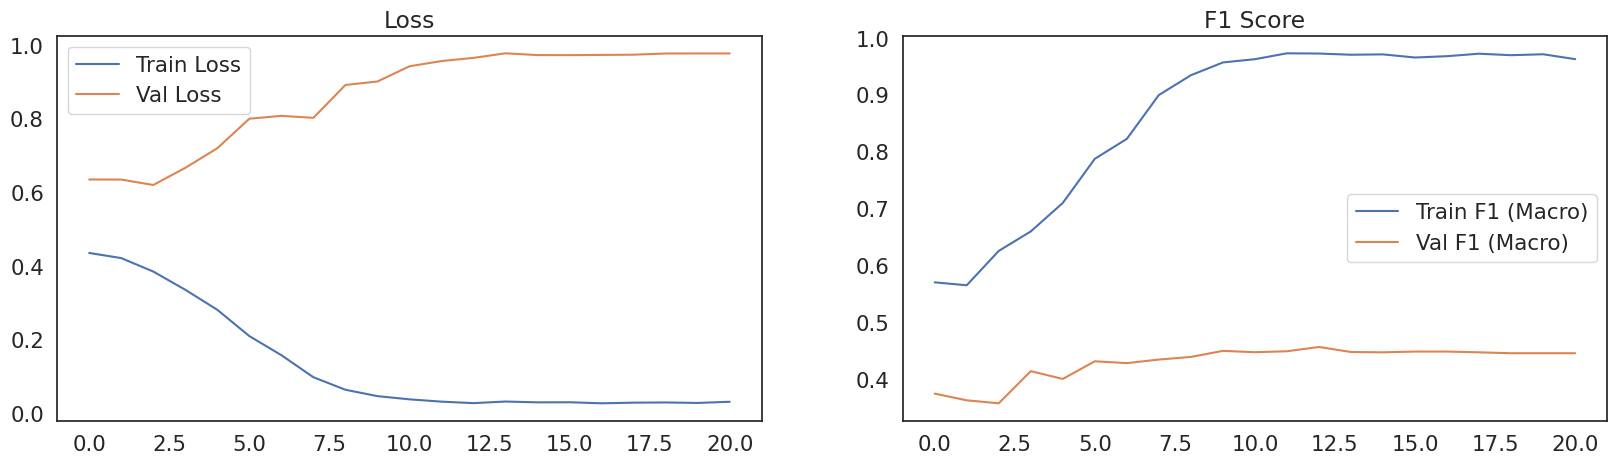

Best Fine-Tuned Validation F1 Score: 0.4571 at epoch 13


In [34]:
# Plotting results
plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 1)
plt.plot(ft_history['train_loss'], label='Train Loss')
plt.plot(ft_history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss')

plt.subplot(1, 2, 2)
plt.plot(ft_history['train_f1'], label='Train F1 (Macro)')
plt.plot(ft_history['val_f1'], label='Val F1 (Macro)')
plt.legend()
plt.title('F1 Score')
plt.show()

print("Best Fine-Tuned Validation F1 Score: {:.4f} at epoch {}".format(best_val_f1, best_ft_epoch))

### 13.3 Confusion Matrix

Generating Confusion Matrix for Transfer Learning Model...

Aggregating predictions for 127 unique images...


Generating Confusion Matrix for Fine-Tuning Model...

Aggregating predictions for 127 unique images...


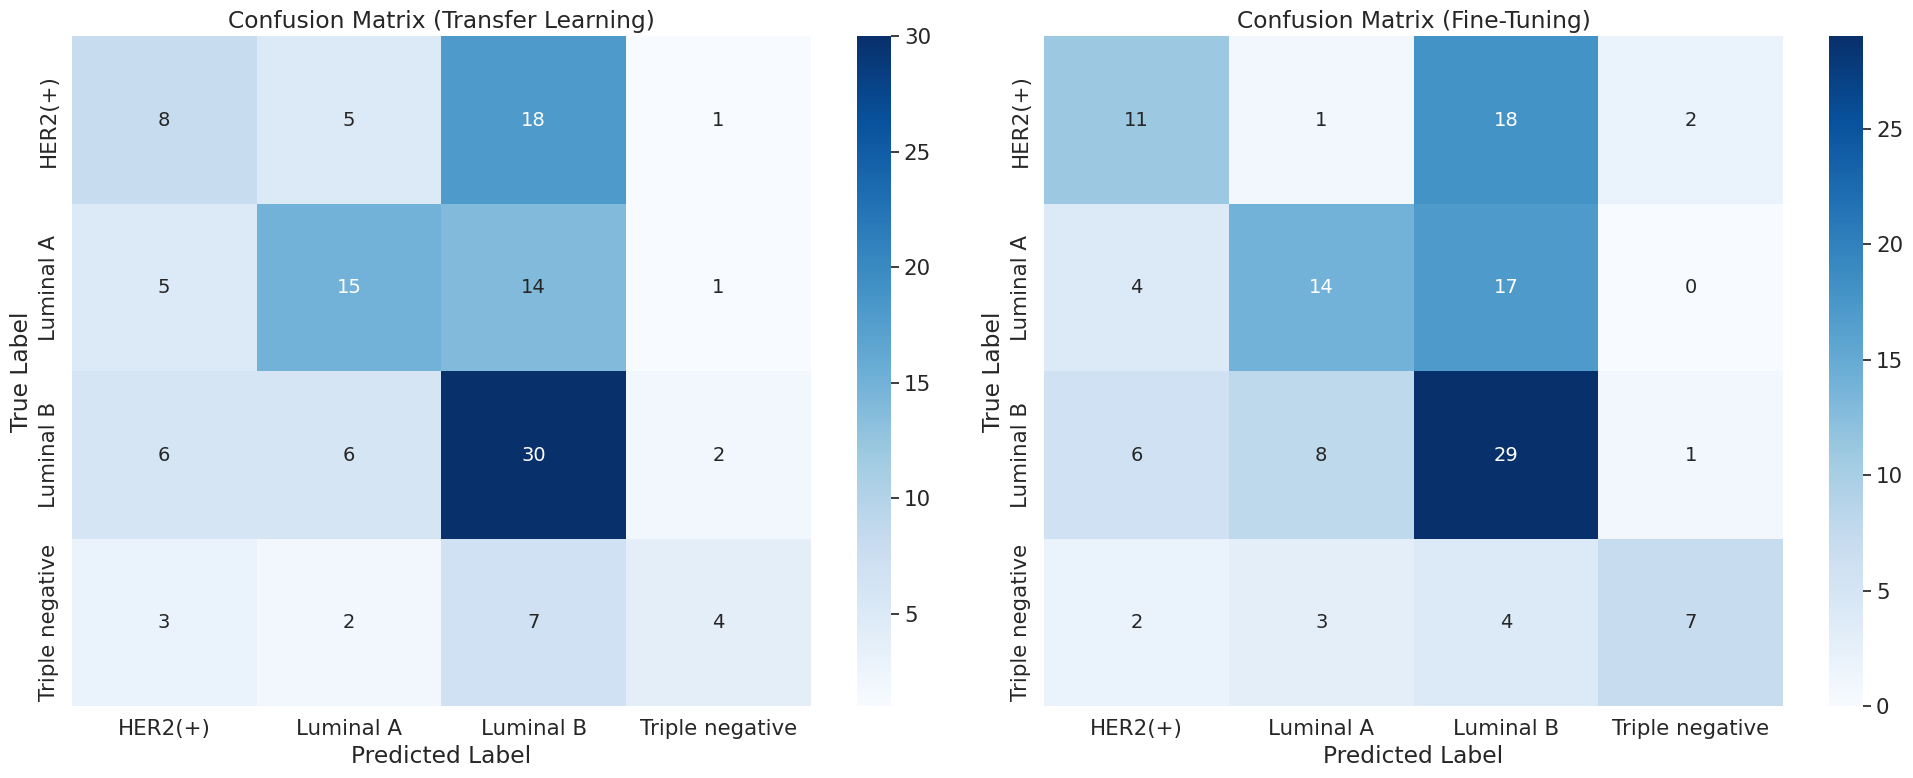

In [35]:

# 1. Get predictions for the Transfer Learning model (from original `model`)
print("Generating Confusion Matrix for Transfer Learning Model...")
y_true_tl, y_pred_tl = get_image_predictions(model, val_loader, device)
cm_tl = confusion_matrix(y_true_tl, y_pred_tl)

# 2. Get predictions for the Fine-Tuning model (from `ft_model`)
print("Generating Confusion Matrix for Fine-Tuning Model...")
y_true_ft, y_pred_ft = get_image_predictions(ft_model, val_loader, device)
cm_ft = confusion_matrix(y_true_ft, y_pred_ft)

# 3. Plotting side-by-side
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# Plot Transfer Learning Confusion Matrix
sns.heatmap(cm_tl, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_, ax=axes[0])
axes[0].set_xlabel('Predicted Label')
axes[0].set_ylabel('True Label')
axes[0].set_title('Confusion Matrix (Transfer Learning)')

# Plot Fine-Tuning Confusion Matrix
sns.heatmap(cm_ft, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_, ax=axes[1])
axes[1].set_xlabel('Predicted Label')
axes[1].set_ylabel('True Label')
axes[1].set_title('Confusion Matrix (Fine-Tuning)')

plt.tight_layout()
plt.show()


Transfer Learning:


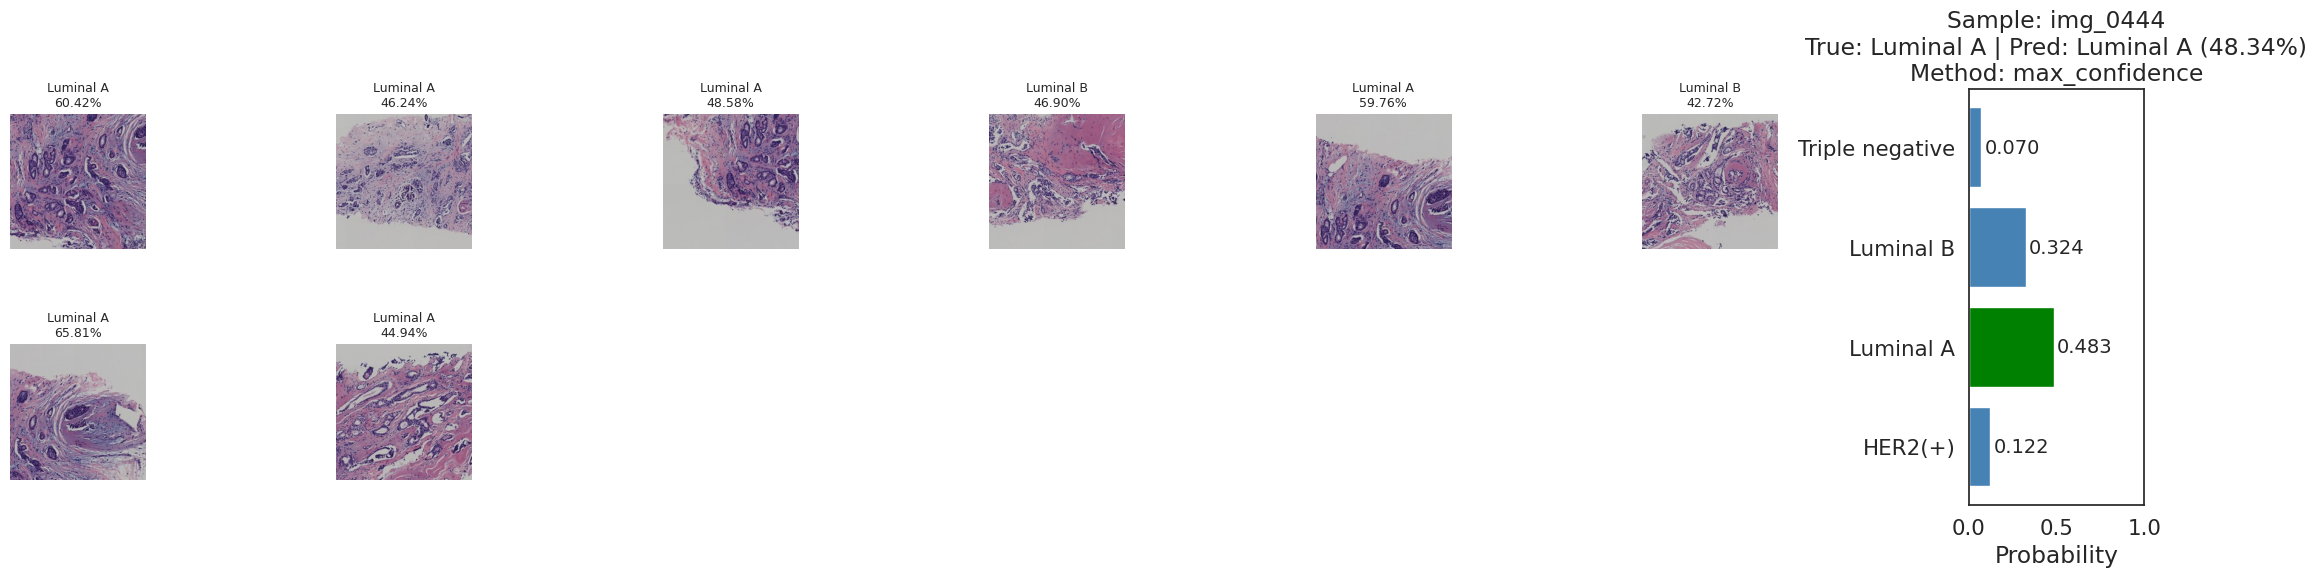

Fine Tuning:


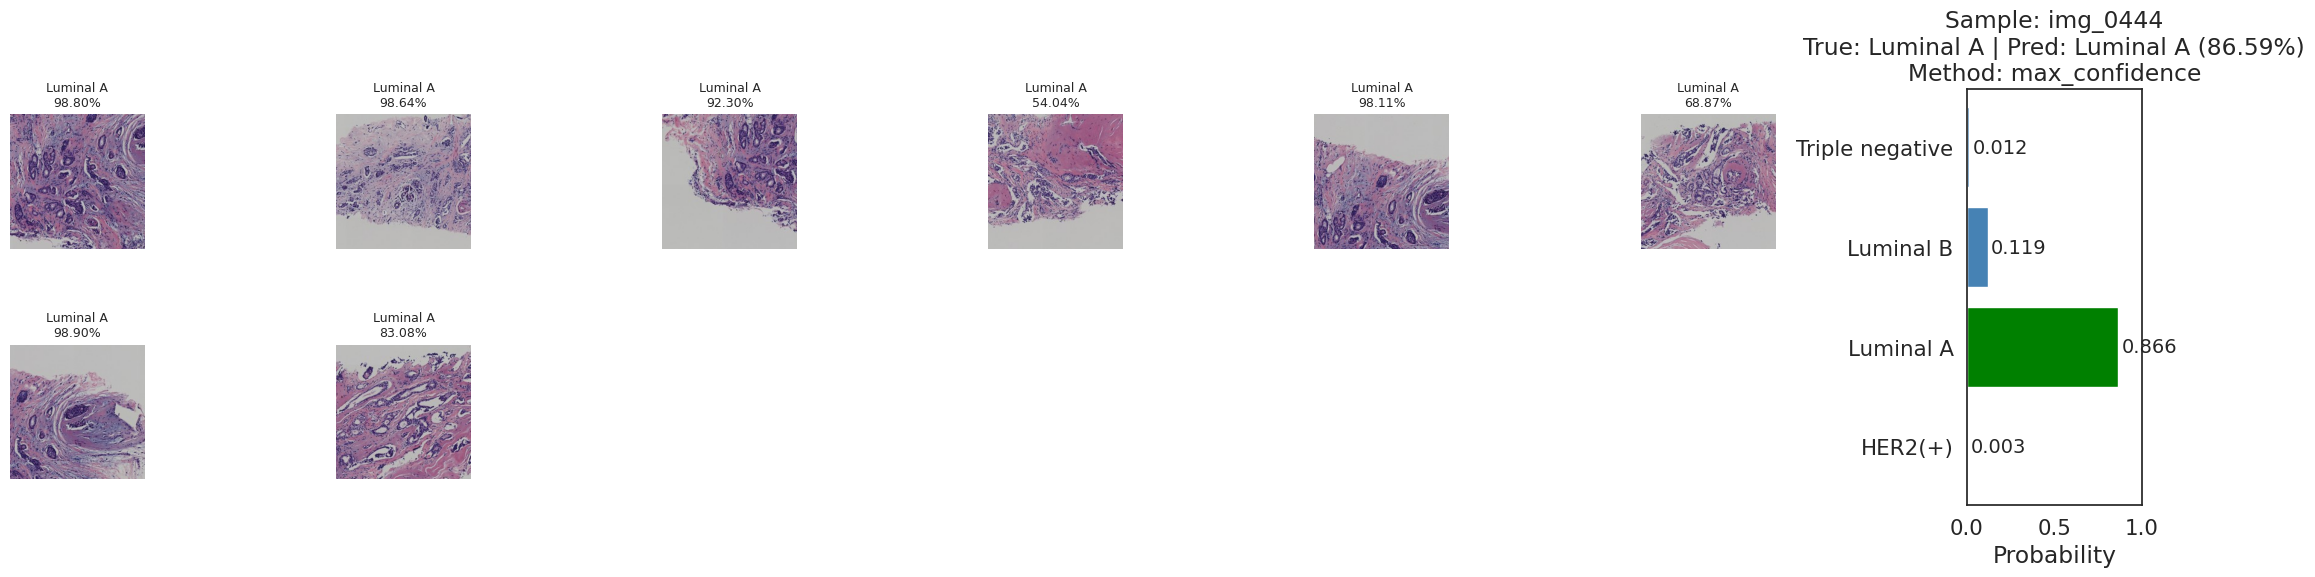

In [38]:
# Visualize a random validation sample
print("Transfer Learning:")
sample_id_plot = np.random.choice(val_loader.dataset.df['sample_id'].unique())
plot_sample_with_predictions(model, val_loader, device, label_encoder, aggregation_method='max_confidence', sample_id=sample_id_plot)
print("Fine Tuning:")
plot_sample_with_predictions(ft_model, val_loader, device, label_encoder, aggregation_method='max_confidence', sample_id=sample_id_plot)

## **14. Submission Creation**

### 14.1 Create Submission Model

In [39]:
sub_model =PhikonClassifier(
    num_classes=num_classes,
    model_name="owkin/phikon",  # Change to "owkin/phikon-v2" for the larger model
    dropout_rate=DROPOUT_RATE
).to(device)
# 2. Load the best weights from the first phase
sub_model.load_state_dict(torch.load('models/best_model_phikonv2_ft.pt'), strict=True)

Loading Phikon backbone: owkin/phikon...


<All keys matched successfully>

### 14.2 Define Transform

In [40]:
val_transform = transforms.Compose([
    transforms.Resize(TARGET_SIZE),
    transforms.ToImage(),
    transforms.ToDtype(torch.float32, scale=True),
])

In [41]:
def generate_submission(model, submission_folder, method='max_confidence', output_csv="submission.csv"):
    """
    Generates a submission file by predicting on patches and aggregating results.
    Uses Phikon preprocessing.
    """
    model.eval()

    # 1. Get list of test patches
    patch_files = sorted([f for f in os.listdir(submission_folder) if f.lower().endswith(('.png', '.jpg', '.jpeg'))])

    print(f"Found {len(patch_files)} patches in {submission_folder}")
    print(f"Aggregation Method: {method}")

    # Store predictions per image
    # Structure: { 'img_0001': {'votes': [], 'probs': []}, ... }
    image_predictions = {}

    print("Running inference with Phikon preprocessing...")
    with torch.no_grad():
        for filename in tqdm(patch_files):
            filepath = os.path.join(submission_folder, filename)

            try:
                sample_id = filename.rsplit('_p', 1)[0]

                if sample_id not in image_predictions:
                    image_predictions[sample_id] = {'probs': []}

                # Load image and apply Phikon preprocessing
                image = Image.open(filepath).convert('RGB')
                processed = phikon_processor(image, return_tensors="pt")
                input_tensor = processed['pixel_values'].to(device)

                # Predict
                outputs = model(input_tensor)
                probs = torch.softmax(outputs, dim=1)

                image_predictions[sample_id]['probs'].append(probs.cpu().numpy()[0])

            except Exception as e:
                print(f"Error processing {filename}: {e}")

    # 3. Aggregate Results
    final_results = []

    print(f"Aggregating results for {len(image_predictions)} unique samples...")

    for sample_id, data in image_predictions.items():
        all_probs = np.array(data['probs']) # Shape: [Num_Patches, Num_Classes]

        # Ensure sample_index has .png extension as requested
        sample_index_name = f"{sample_id}.png"

        if len(all_probs) == 0:
            final_results.append({'sample_index': sample_index_name, 'label': "Luminal A"}) # Default fallback
            continue

        if method == 'majority_voting':
            # Get class prediction for each patch
            patch_preds = np.argmax(all_probs, axis=1)
            # Find most frequent class
            counts = np.bincount(patch_preds)
            final_class_idx = np.argmax(counts)

        elif method == 'max_confidence':
            # Option A: Average probabilities (Soft Voting) - usually best/safest
            avg_probs = np.mean(all_probs, axis=0)
            final_class_idx = np.argmax(avg_probs)

            # Option B: Strict Max Confidence (Uncomment if you prefer this)
            # max_probs = np.max(all_probs, axis=0)
            # final_class_idx = np.argmax(max_probs)

        # Decode Label
        pred_label = label_encoder.inverse_transform([final_class_idx])[0]
        final_results.append({'sample_index': sample_index_name, 'label': pred_label})

    # 4. Create Pandas DataFrame and Save
    df_submission = pd.DataFrame(final_results)

    # Ensure correct column order
    df_submission = df_submission[['sample_index', 'label']]

    # Sort by sample_index for neatness
    df_submission.sort_values('sample_index', inplace=True)

    # Save to CSV
    df_submission.to_csv(output_csv, index=False)

    print(f"Submission saved to {output_csv}")
    print(df_submission.head())

    return df_submission



### 14.3 Create the Submission CSV

In [42]:
# Example Usage:
# Replace 'path/to/SUBMISSION_PATCHES' with the actual path
# If your folder is just named SUBMISSION_PATCHES in current dir:

now = datetime.now()
date_time_str = now.strftime("%d_%b-%H_%M")

sub_dir = os.path.join(os.path.pardir, "submission_csvs")
OUTPUT_NAME = os.path.join(sub_dir, f"submission_ft--{date_time_str}.csv")


os.makedirs(sub_dir, exist_ok=True)

# Check if folder exists
if os.path.exists(SUBMISSION_PATCHES_OUT):
    # Method 1: Max Confidence / Average Probability (Recommended)
    df_sub_max_conf = generate_submission(sub_model, SUBMISSION_PATCHES_OUT, method='max_confidence', output_csv=OUTPUT_NAME)
    print(f"Submission CSV saved to: {OUTPUT_NAME}")

    # Method 2: Majority Voting (Optional, uncomment to run)
    # df_sub_majority_voting = generate_submission(sub_model, SUBMISSION_PATCHES_OUT, method='majority_voting', output_csv="submission_voting.csv")
else:
    print(f"Directory '{SUBMISSION_PATCHES_OUT}' not found. Please create it or set the correct path.")

Found 2052 patches in ../an2dl2526c2/preprocessing_results/submission_patches
Aggregation Method: max_confidence
Running inference with Phikon preprocessing...


100%|██████████| 2052/2052 [21:21<00:00,  1.60it/s]

Aggregating results for 477 unique samples...
Submission saved to ../submission_csvs/submission_ft--08_Dec-23_45.csv
   sample_index      label
0  img_0000.png  Luminal B
1  img_0001.png  Luminal B
2  img_0002.png  Luminal A
3  img_0003.png  Luminal B
4  img_0004.png  Luminal A
Submission CSV saved to: ../submission_csvs/submission_ft--08_Dec-23_45.csv
